In [1]:
!pip install torch transformers datasets spacy matplotlib seqeval

In [2]:
!pip install evaluate

In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import (
    BertForSequenceClassification, BertTokenizerFast,
    GPT2LMHeadModel, GPT2TokenizerFast,
    T5ForConditionalGeneration, T5TokenizerFast,
    Trainer, TrainingArguments, get_linear_schedule_with_warmup,
    DataCollatorWithPadding, DataCollatorForLanguageModeling,
    DataCollatorForSeq2Seq, AutoTokenizer,
    AutoModelForTokenClassification, pipeline, DataCollatorForTokenClassification,
    AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, EvalPrediction,
    AutoConfig
)
from datasets import load_dataset, DatasetDict
import spacy
import matplotlib.pyplot as plt
import time
import math
import numpy as np
import os
import random
from torch.optim import AdamW
import evaluate
import json
import argparse

In [56]:
%%bash
cat > fine_tune.py << 'EOF'

import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "transformers"])

import argparse
import torch
from datasets import load_dataset
from evaluate import load as load_metric
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForTokenClassification,
    AutoModelForSeq2SeqLM,
    DataCollatorWithPadding,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


def fine_tune(args):
    ds = load_dataset(args.dataset, args.dataset_config) if args.dataset_config else load_dataset(args.dataset)
    train_split = ds.get('train')
    eval_split  = ds.get('validation') or ds.get('test')

    tokenizer = AutoTokenizer.from_pretrained(args.model_name)
    if args.task in ['seq-classification']:
        model = AutoModelForSequenceClassification.from_pretrained(args.model_name, num_labels=args.num_labels)
        data_collator = DataCollatorWithPadding(tokenizer)
    elif args.task in ['token-classification']:
        model = AutoModelForTokenClassification.from_pretrained(args.model_name, num_labels=args.num_labels)
        data_collator = DataCollatorWithPadding(tokenizer)
    elif args.task in ['seq2seq']:
        model = AutoModelForSeq2SeqLM.from_pretrained(args.model_name)
        data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
    else:
        raise ValueError("Unsupported task")

    def preprocess_fn(batch):
        if args.task == 'seq-classification':
            return tokenizer(batch[args.text_column],
                             truncation=True,
                             padding='max_length',
                             max_length=args.max_length)
        elif args.task == 'token-classification':
            tokenized = tokenizer(batch[args.text_column], is_split_into_words=True,
                                  truncation=True, padding='max_length', max_length=args.max_length)
            labels = []
            for i, word_ids in enumerate(tokenized.word_ids(batch_index=i) for i in range(len(batch[args.label_column]))):
                word_ids = word_ids
                prev = None; label_ids = []
                for wid in word_ids:
                    if wid is None:
                        label_ids.append(-100)
                    elif wid != prev:
                        label_ids.append(batch[args.label_column][i][wid])
                    else:
                        label_ids.append(-100)
                    prev = wid
                labels.append(label_ids)
            tokenized["labels"] = labels
            return tokenized
        elif args.task == 'seq2seq':
            inputs = tokenizer(batch[args.text_column], truncation=True, padding='max_length', max_length=args.max_length)
            targets = tokenizer(batch[args.summary_column], truncation=True,
                                padding='max_length', max_length=args.target_length)
            inputs["labels"] = targets["input_ids"]
            return inputs

    cols_to_remove = [c for c in ds['train'].column_names if c not in [args.text_column, args.label_column, args.summary_column]]
    tokenized = ds.map(preprocess_fn, batched=True, remove_columns=cols_to_remove)

    training_args = TrainingArguments(
        output_dir=args.output_dir,
        num_train_epochs=args.epochs,
        per_device_train_batch_size=args.train_bs,
        per_device_eval_batch_size=args.eval_bs,
        learning_rate=args.lr,
        save_strategy="epoch",
        logging_steps=args.log_steps,
        no_cuda=False,
        fp16=True,
        do_train=True,
        do_eval=True,
        eval_steps=args.log_steps,
        save_steps=args.log_steps,
        disable_tqdm=False,
        report_to=[]
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized['train'],
        eval_dataset=tokenized['validation'] if 'validation' in tokenized else tokenized['test'],
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    trainer.train()
    results = trainer.evaluate()

    print(results)




if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Fine-tune HF Transformer")
    parser.add_argument("--model_name", type=str, required=True)
    parser.add_argument("--dataset", type=str, required=True)
    parser.add_argument("--dataset_config", type=str, default=None)
    parser.add_argument("--task", choices=["seq-classification","token-classification","seq2seq"], required=True)
    parser.add_argument("--text_column", type=str, default="text")
    parser.add_argument("--label_column", type=str, default="label")
    parser.add_argument("--summary_column", type=str, default="summary")
    parser.add_argument("--num_labels", type=int, default=2)
    parser.add_argument("--max_length", type=int, default=128)
    parser.add_argument("--target_length", type=int, default=64)
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_bs", type=int, default=16)
    parser.add_argument("--eval_bs", type=int, default=32)
    parser.add_argument("--lr", type=float, default=5e-5)
    parser.add_argument("--log_steps", type=int, default=50)
    parser.add_argument("--output_dir", type=str, default="./fine_tuned")
    args = parser.parse_args()
    fine_tune(args)
EOF

In [7]:
raw = load_dataset("imdb")
small_train = raw["train"].shuffle(seed=42).select(range(5000))
small_test  = raw["test"].shuffle(seed=42).select(range(1000))
datasets = DatasetDict({"train": small_train, "test": small_test})
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
max_length = 128
def tokenize_fn(batch):
    return tokenizer(batch["text"],
                     padding="max_length",
                     truncation=True,
                     max_length=max_length)
tokenized = datasets.map(tokenize_fn, batched=True)
tokenized.set_format(type="torch",
                     columns=["input_ids", "attention_mask", "label"])
train_loader = DataLoader(tokenized["train"],
                          batch_size=32,
                          shuffle=True,
                          pin_memory=True)
test_loader  = DataLoader(tokenized["test"],
                          batch_size=32,
                          shuffle=False,
                          pin_memory=True)
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Train batches: 157, Test batches: 32


In [8]:
vocab_size = tokenizer.vocab_size
embed_dim  = 128
hidden_dim = 128
num_heads  = 4
ff_dim     = 256
num_layers = 2
num_classes = 2

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        _, (h_n, _) = self.lstm(x)
        logits = self.classifier(h_n[-1])
        return logits

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, num_classes, max_len=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids) + self.pos_encoding[:, :input_ids.size(1), :]
        # Create padding mask for Transformer
        src_key_padding_mask = attention_mask == 0 if attention_mask is not None else None
        enc = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        pooled = enc.mean(dim=1)
        logits = self.classifier(pooled)
        return logits

rnn_model = RNNClassifier(vocab_size, embed_dim, hidden_dim, num_classes).to(device)
trans_model = TransformerClassifier(vocab_size, embed_dim, num_heads, ff_dim, num_layers, num_classes).to(device)

print("RNN model:", rnn_model)
print("Transformer model:", trans_model)


RNN model: RNNClassifier(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)
Transformer model: TransformerClassifier(
  (embedding): Embedding(30522, 128)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=128, o

In [9]:
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, total_correct / total

def eval_model(model, loader, device):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, total_correct / total

rnn_opt = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)
trans_opt = torch.optim.Adam(trans_model.parameters(), lr=1e-3)

for name, model, opt in [("RNN", rnn_model, rnn_opt),
                         ("Transformer", trans_model, trans_opt)]:
    start = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, opt, device)
    val_loss, val_acc = eval_model(model, test_loader, device)
    elapsed = time.time() - start
    print(f"{name} → "
          f"Train loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")


RNN → Train loss: 0.6952, Acc: 0.5104 | Val loss: 0.6883, Acc: 0.5490 | Time: 2.1s
Transformer → Train loss: 0.6574, Acc: 0.5972 | Val loss: 0.5999, Acc: 0.6660 | Time: 2.1s


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1/5
  RNN: Train Acc 0.5874, Val Acc 0.5920, Train Loss 0.6744, Val Loss 0.6785
  Transformer: Train Acc 0.7524, Val Acc 0.7580, Train Loss 0.5030, Val Loss 0.4830
Epoch 2/5
  RNN: Train Acc 0.6704, Val Acc 0.4960, Train Loss 0.6100, Val Loss 0.6966
  Transformer: Train Acc 0.8438, Val Acc 0.7720, Train Loss 0.3517, Val Loss 0.4934
Epoch 3/5
  RNN: Train Acc 0.7048, Val Acc 0.6330, Train Loss 0.5551, Val Loss 0.7159
  Transformer: Train Acc 0.9184, Val Acc 0.7620, Train Loss 0.2172, Val Loss 0.5964
Epoch 4/5
  RNN: Train Acc 0.8078, Val Acc 0.6120, Train Loss 0.4233, Val Loss 0.7550
  Transformer: Train Acc 0.9638, Val Acc 0.7620, Train Loss 0.1036, Val Loss 0.7778
Epoch 5/5
  RNN: Train Acc 0.8548, Val Acc 0.6120, Train Loss 0.3119, Val Loss 0.8688
  Transformer: Train Acc 0.9890, Val Acc 0.7650, Train Loss 0.0377, Val Loss 1.1029


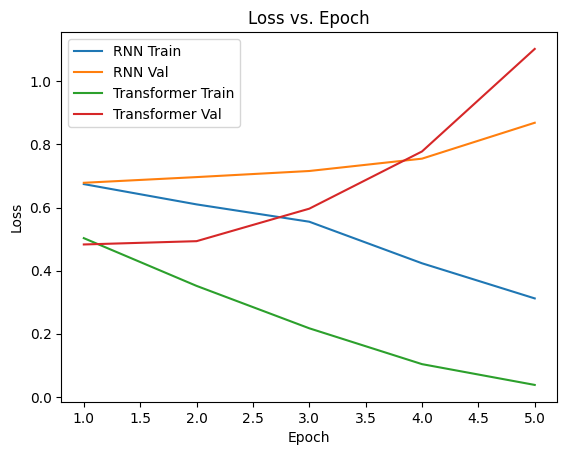

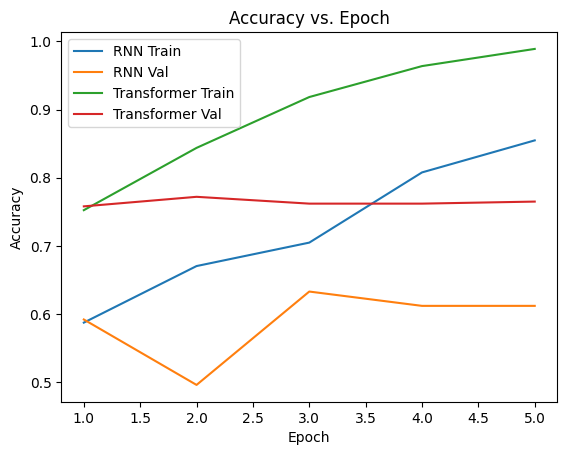

In [10]:
epochs = 5

metrics = {
    "RNN": {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []},
    "Transformer": {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
}

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")
    for name, model, optimizer in [
        ("RNN", rnn_model, rnn_opt),
        ("Transformer", trans_model, trans_opt)
    ]:
        t_loss, t_acc = train_epoch(model, train_loader, optimizer, device)
        v_loss, v_acc = eval_model(model, test_loader, device)
        metrics[name]["train_loss"].append(t_loss)
        metrics[name]["val_loss"].append(v_loss)
        metrics[name]["train_acc"].append(t_acc)
        metrics[name]["val_acc"].append(v_acc)
        print(f"  {name}: Train Acc {t_acc:.4f}, Val Acc {v_acc:.4f}, Train Loss {t_loss:.4f}, Val Loss {v_loss:.4f}")

plt.figure()
for name in metrics:
    plt.plot(range(1, epochs+1), metrics[name]["train_loss"], label=f"{name} Train")
    plt.plot(range(1, epochs+1), metrics[name]["val_loss"],   label=f"{name} Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.show()

plt.figure()
for name in metrics:
    plt.plot(range(1, epochs+1), metrics[name]["train_acc"], label=f"{name} Train")
    plt.plot(range(1, epochs+1), metrics[name]["val_acc"],   label=f"{name} Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.show()


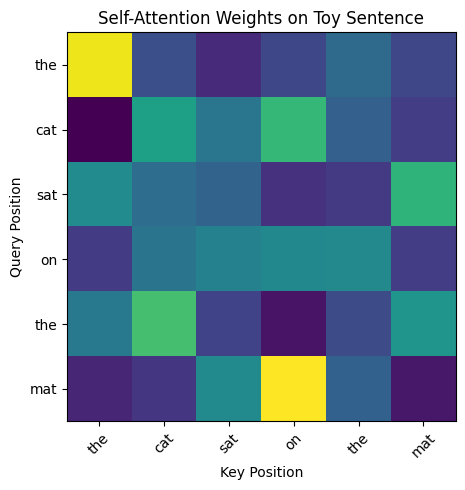

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.scale = embed_dim ** -0.5

    def forward(self, x):
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        weights = F.softmax(scores, dim=-1)
        out = torch.matmul(weights, V)
        return out, weights

tokens = ["the", "cat", "sat", "on", "the", "mat"]
seq_len = len(tokens)
embed_dim = 16

torch.manual_seed(42)
x = torch.randn(1, seq_len, embed_dim).to(device)

attn = SelfAttention(embed_dim).to(device)
_, weights = attn(x)

weights = weights[0].cpu().detach().numpy()

plt.figure(figsize=(6, 5))
plt.imshow(weights)
plt.xticks(range(seq_len), tokens, rotation=45)
plt.yticks(range(seq_len), tokens)
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.title("Self-Attention Weights on Toy Sentence")
plt.tight_layout()
plt.show()


In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, padding_mask=None):
        attn_out, _ = self.attn(x, x, x, key_padding_mask=padding_mask)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

In [13]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim,
                 num_layers, num_classes, max_len=512, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim, max_len)
        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        x = self.pos_encoding(x)
        padding_mask = (attention_mask == 0) if attention_mask is not None else None
        for layer in self.layers:
            x = layer(x, padding_mask)
        pooled = x.mean(dim=1)
        return self.classifier(pooled)

Epoch 1/8 — Train Loss: 0.6971, Acc: 0.5500 | Val Loss: 0.6277, Acc: 0.6500
Epoch 2/8 — Train Loss: 0.6076, Acc: 0.6674 | Val Loss: 0.5360, Acc: 0.7140
Epoch 3/8 — Train Loss: 0.5019, Acc: 0.7458 | Val Loss: 0.5309, Acc: 0.7600
Epoch 4/8 — Train Loss: 0.4098, Acc: 0.8126 | Val Loss: 0.5599, Acc: 0.7190
Epoch 5/8 — Train Loss: 0.3134, Acc: 0.8704 | Val Loss: 0.5704, Acc: 0.7620
Epoch 6/8 — Train Loss: 0.2076, Acc: 0.9188 | Val Loss: 0.6675, Acc: 0.7660
Epoch 7/8 — Train Loss: 0.1315, Acc: 0.9528 | Val Loss: 0.8241, Acc: 0.7650
Epoch 8/8 — Train Loss: 0.0707, Acc: 0.9800 | Val Loss: 0.9877, Acc: 0.7630


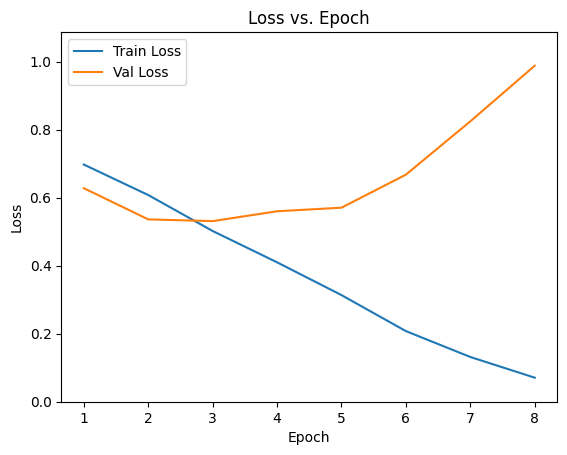

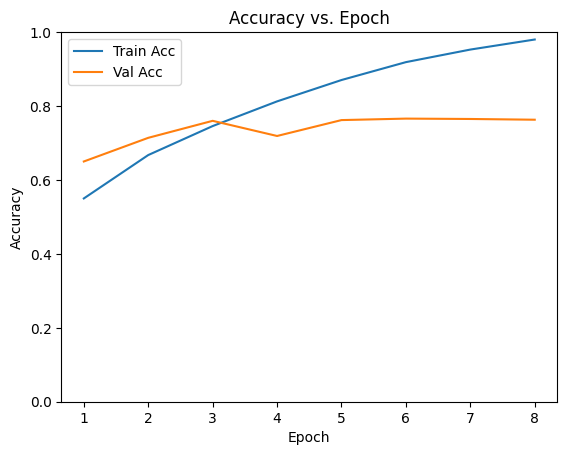

In [14]:
model = TransformerClassifier(
    vocab_size=tokenizer.vocab_size,
    embed_dim=256,
    num_heads=8,
    ff_dim=512,
    num_layers=4,
    num_classes=2,
    dropout=0.2,
).to(device)

epochs = 8
total_steps = len(train_loader) * epochs
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

train_losses, train_accs = [], []
val_losses,   val_accs   = [], []

for epoch in range(1, epochs + 1):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total
    val_loss /= val_total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}/{epochs} — "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

epochs_range = list(range(1, epochs + 1))

plt.figure()
for name, series in [("RNN" if isinstance(model, RNNClassifier) else "Transformer", None)]: pass
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.ylim(0, max(val_losses + train_losses) * 1.1)
plt.show()

plt.figure()
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs,   label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.ylim(0.0, 1.0)
plt.show()


In [15]:
raw = load_dataset("imdb")
small_train = raw["train"].shuffle(seed=42).select(range(2000))
small_test  = raw["test"].shuffle(seed=42).select(range(500))

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
def preprocess(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_enc = small_train.map(preprocess, batched=True)
test_enc  = small_test.map(preprocess, batched=True)
for ds in (train_enc, test_enc):
    ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])

data_collator = DataCollatorWithPadding(tokenizer)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
).to(device)

training_args = TrainingArguments(
    output_dir="./bert_finetune",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    logging_steps=50,
    report_to=None,
    do_train=True,
    do_eval=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=test_enc,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

bert_results = trainer.evaluate()
print("BERT eval:", bert_results)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-9e880f45dc82>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: akhjan18 (akhjan18-kazakh-british-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.628700
100,0.458100
150,0.316100
200,0.297700
250,0.260400
300,0.172000
350,0.175100


BERT eval: {'eval_loss': 0.4369467794895172, 'eval_accuracy': 0.862, 'eval_runtime': 3.493, 'eval_samples_per_second': 143.144, 'eval_steps_per_second': 4.581, 'epoch': 3.0}


In [16]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize_fn(examples):
    return tokenizer(examples["text"], return_special_tokens_mask=True)

tokenized = dataset.map(
    tokenize_fn,
    batched=True,
    remove_columns=["text"]
)

block_size = 128
def group_texts(examples):
    concatenated = sum(examples["input_ids"], [])
    total_length = len(concatenated) // block_size * block_size
    result = [
        concatenated[i : i + block_size]
        for i in range(0, total_length, block_size)
    ]
    return {"input_ids": result}

lm_dataset = tokenized["train"].map(
    group_texts,
    batched=True,
    remove_columns=tokenized["train"].column_names
)

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

training_args = TrainingArguments(
    output_dir="./gpt2_finetune",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=500,
    logging_steps=100,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to=None,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()


<ipython-input-16-5e7fddf68f65>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,3.844700
200,3.672900
300,3.616200
400,3.581600
500,3.546500
600,3.521000
700,3.500500
800,3.515800
900,3.488100
1000,3.477700


TrainOutput(global_step=3501, training_loss=3.4292574639117435, metrics={'train_runtime': 2163.801, 'train_samples_per_second': 25.881, 'train_steps_per_second': 1.618, 'total_flos': 3658153771008000.0, 'train_loss': 3.4292574639117435, 'epoch': 3.0})

In [17]:
seed = "To be, or not to be, that is the question:"
input_ids = tokenizer(seed, return_tensors="pt").input_ids.to(device)
gpt_outputs = model.generate(
    input_ids,
    max_length=100,
    num_return_sequences=3,
    do_sample=True,
    top_p=0.9,
    temperature=0.8
)
print("\nGPT-2 generations:")
for i, out in enumerate(gpt_outputs):
    print(f"\n=== Sample {i+1} ===")
    print(tokenizer.decode(out, skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



GPT-2 generations:

=== Sample 1 ===
To be, or not to be, that is the question: what does this mean ? " 
 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

=== Sample 2 ===
To be, or not to be, that is the question: Is this a game that can be played in a different way and still have all the elements that have been introduced to it ? " He continued : " In the past , we had to keep on playing the same game in different ways . 
 " In the past , we had to keep on playing the same game in different ways , and in order to achieve that , we had to have the same game as the last game that we

=== Sample 3 ===
To be, or not to be, that is the question: What is the significance of the song ? 
 The song is a bit of a cliché : if it was just an acoustic version , then I wouldn 't be singing . " The song is played at the same time as the chorus of " It 's the Last Night " , the song that wa

In [18]:
raw = load_dataset("xsum")
small_train = raw["train"].shuffle(seed=42).select(range(2000))
small_val   = raw["validation"].shuffle(seed=42).select(range(500))

tokenizer = T5TokenizerFast.from_pretrained("t5-small")
max_input_length = 256
max_target_length = 64

def preprocess(batch):
    inputs = tokenizer(
        batch["document"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )
    targets = tokenizer(
        batch["summary"],
        padding="max_length",
        truncation=True,
        max_length=max_target_length
    )
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": targets["input_ids"],
    }

train_enc = small_train.map(preprocess, batched=True, remove_columns=["document","summary"])
val_enc   = small_val.map(preprocess,   batched=True, remove_columns=["document","summary"])
for ds in (train_enc, val_enc):
    ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

data_collator = DataCollatorForSeq2Seq(tokenizer, model="t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

training_args = TrainingArguments(
    output_dir="./t5_summarization",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    save_strategy="no",
    learning_rate=5e-5,
    logging_steps=50,
    report_to=None,
    do_train=True,
    do_eval=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

t5_results = trainer.evaluate()
print("\nT5 eval:", t5_results)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

<ipython-input-18-f35228571a24>:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
50,6.740300
100,2.106500
150,1.639700
200,1.564000
250,1.499600
300,1.493200
350,1.461200
400,1.459600
450,1.457500
500,1.455700



T5 eval: {'eval_loss': 1.334236979484558, 'eval_runtime': 3.3785, 'eval_samples_per_second': 147.996, 'eval_steps_per_second': 9.472, 'epoch': 3.0}


In [19]:
print("\nT5 examples:")
for doc in small_val[:3]["document"]:
    inputs = tokenizer(doc, return_tensors="pt",
                       max_length=256, truncation=True).to(device)
    summary_ids = model.generate(
        **inputs,
        max_length=64,
        num_beams=4,
        early_stopping=True
    )
    print("\n--- Input ---")
    print(doc[:200], "…")
    print("\n--- Output ---")
    print(tokenizer.decode(summary_ids[0], skip_special_tokens=True))


T5 examples:

--- Input ---
Patrick Joseph Connors, 59, his son Patrick Dean Connors, 39, and nephew William Connors, 36, denied requiring a person to perform forced or compulsory labour between 2010 and 2013.
They were convicte …

--- Output ---
Connors, 59, son Patrick Dean Connors, 39, and nephew William Connors, 36, were jailed for two-and-a-half years.

--- Input ---
The visitors were closing in on three points thanks to Christian Nade's first-half penalty and a fine finish from Robert Thomson.
But Martin Boyle's late effort - after Daniel Harvie scored an own goa …

--- Output ---
Hibs beat Dundee United 1-0 in their first-half to claim a point in the first half thanks to a mistake from goalkeeper Robert Thomson.

--- Input ---
Kamiyah Mobley, who was abducted in July 1998, was found after a tip.
Authorities in Walterboro, South Carolina, have charged Gloria Williams, 51, with kidnapping.
Ms Mobley was living under another n …

--- Output ---
A woman has been charged with kidnap

In [20]:
nlp = spacy.load("en_core_web_sm")

text = "Apple is unveiling their new iPhone Operating system in coming June as always."

doc = nlp(text)
print("spaCy NER Results:")
for ent in doc.ents:
    print(f"  {ent.text:20} → {ent.label_}")

spaCy NER Results:
  Apple                → ORG
  coming June          → DATE


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

tokenizer_ner = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
model_ner     = AutoModelForTokenClassification.from_pretrained(
    "dbmdz/bert-large-cased-finetuned-conll03-english"
)
model_ner.to(device)

text = "Apple is unveiling their new iPhone Operating system in coming June as always."
inputs = tokenizer_ner(text, return_tensors="pt", truncation=True, padding=True).to(device)
with torch.no_grad():
    logits = model_ner(**inputs).logits
pred_ids = logits.argmax(dim=-1)[0].tolist()
labels   = [model_ner.config.id2label[i] for i in pred_ids]
tokens   = tokenizer_ner.convert_ids_to_tokens(inputs["input_ids"][0])

for tok, lab in zip(tokens, labels):
    print(f"{tok:12} → {lab}")

Running on cuda:0


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[CLS]        → O
Apple        → I-ORG
is           → O
un           → O
##ve         → O
##iling      → O
their        → O
new          → O
iPhone       → I-MISC
Operating    → I-MISC
system       → I-MISC
in           → O
coming       → O
June         → O
as           → O
always       → O
.            → O
[SEP]        → O


In [22]:
pos_text = "The quick brown fox jumps over the lazy dog."
doc_pos = nlp(pos_text)
print("\nspaCy POS Tagging:")
for token in doc_pos:
    print(f"  {token.text:10} → {token.pos_}")


spaCy POS Tagging:
  The        → DET
  quick      → ADJ
  brown      → ADJ
  fox        → NOUN
  jumps      → VERB
  over       → ADP
  the        → DET
  lazy       → ADJ
  dog        → NOUN
  .          → PUNCT


In [23]:
tokenizer_pos = AutoTokenizer.from_pretrained("vblagoje/bert-english-uncased-finetuned-pos")
model_pos     = AutoModelForTokenClassification.from_pretrained("vblagoje/bert-english-uncased-finetuned-pos")

pos_pipeline = pipeline(
    "token-classification",
    model=model_pos,
    tokenizer=tokenizer_pos,
    aggregation_strategy="simple"
)

print("\nTransformer (BERT) POS Tagging:")
for tok in pos_pipeline(pos_text):
    print(f"  {tok['word']:10} → {tok['entity_group']} ({tok['score']:.2f})")

Some weights of the model checkpoint at vblagoje/bert-english-uncased-finetuned-pos were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0



Transformer (BERT) POS Tagging:
  the        → DET (1.00)
  quick brown → ADJ (0.97)
  fox        → NOUN (1.00)
  jumps      → VERB (1.00)
  over       → ADP (1.00)
  the        → DET (1.00)
  lazy       → ADJ (1.00)
  dog        → NOUN (1.00)
  .          → PUNCT (1.00)


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
datasets = load_dataset("conll2003")
label_list = datasets["train"].features["ner_tags"].feature.names

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased", num_labels=len(label_list)
).to(device)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], is_split_into_words=True,
        truncation=True, padding="max_length", max_length=128
    )
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = datasets.map(
    tokenize_and_align_labels, batched=True, remove_columns=datasets["train"].column_names
)

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load('seqeval')

def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)
    true_labels = [
        [label_list[l] for l in lab if l != -100]
        for lab in labels
    ]
    true_preds = [
        [label_list[p] for p, l in zip(pred, lab) if l != -100]
        for pred, lab in zip(preds, labels)
    ]
    results = metric.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

training_args = TrainingArguments(
    output_dir="./conll2003-ner",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=None,
    no_cuda=False,
    fp16=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
metrics = trainer.evaluate()
print("CoNLL-2003 NER results:", metrics)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

<ipython-input-25-3b6062c3d81e>:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.183000
1000,0.044600
1500,0.028400
2000,0.019500
2500,0.014500


CoNLL-2003 NER results: {'eval_loss': 0.03458889573812485, 'eval_precision': 0.948073701842546, 'eval_recall': 0.9535040431266847, 'eval_f1': 0.9507811187636485, 'eval_accuracy': 0.9915827211971241, 'eval_runtime': 7.1301, 'eval_samples_per_second': 455.811, 'eval_steps_per_second': 14.305, 'epoch': 3.0}


In [26]:
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

conll = load_dataset("conll2003")["validation"]

y_true, y_pred = [], []
for tokens, tags in zip(conll["tokens"], conll["ner_tags"]):
    true_tags = [conll.features["ner_tags"].feature.names[t] for t in tags]
    doc = nlp(" ".join(tokens))
    pred_tags = ["O"] * len(tokens)
    for ent in doc.ents:
        start, end = ent.start_char, ent.end_char
        char_to_token = []
        cum = 0
        for i,t in enumerate(tokens):
            cum += len(t)+1
            char_to_token.append(i)
        for i in range(len(tokens)):
            if cum >= start and cum <= end:
                pred_tags[i] = ent.label_
    y_true.append(true_tags)
    y_pred.append(pred_tags)

print("spaCy NER on CoNLL-2003:")
print(classification_report(y_true, y_pred))

spaCy NER on CoNLL-2003:


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         LOC       0.00      0.00      0.00      1837
        MISC       0.00      0.00      0.00       922
         ORG       0.00      0.00      0.00      1341
         PER       0.00      0.00      0.00      1842

   micro avg       0.00      0.00      0.00      5942
   macro avg       0.00      0.00      0.00      5942
weighted avg       0.00      0.00      0.00      5942



In [28]:
raw_train = load_dataset("conll2003")["train"]
raw_val   = load_dataset("conll2003")["validation"]
def dump(split, raw_split, filename):
    records = []
    for tokens, tags in zip(raw_split["tokens"], raw_split["ner_tags"]):
        records.append({"tokens": tokens, "ner_tags": tags})
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(records, f, ensure_ascii=False, indent=2)

dump("train", raw_train,      "train.json")
dump("validation", raw_val,   "validation.json")

raw_custom = load_dataset("json", data_files={
    "train": "train.json",
    "validation": "validation.json"
})

custom_tokenized = raw_custom.map(
    tokenize_and_align_labels, batched=True, remove_columns=raw_custom["train"].column_names
)

trainer_custom = Trainer(
    model=model,
    args=training_args,
    train_dataset=custom_tokenized["train"],
    eval_dataset=custom_tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_custom.train()
print("Custom NER results:", trainer_custom.evaluate())

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

<ipython-input-28-c9d937e1c135>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_custom = Trainer(


Step,Training Loss
500,0.013400
1000,0.008700
1500,0.005200
2000,0.004700
2500,0.003000


Custom NER results: {'eval_loss': 0.043425969779491425, 'eval_precision': 0.9462257849031396, 'eval_recall': 0.9545148247978437, 'eval_f1': 0.9503522307950351, 'eval_accuracy': 0.9911930323636576, 'eval_runtime': 7.1377, 'eval_samples_per_second': 455.327, 'eval_steps_per_second': 14.29, 'epoch': 3.0}


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

raw = load_dataset("imdb")
small_train = raw["train"].shuffle(seed=42).select(range(5000))
small_test  = raw["test"].shuffle(seed=42).select(range(1000))

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
max_len = 128

def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_len)

train_enc = small_train.map(preprocess, batched=True)
test_enc  = small_test.map(preprocess, batched=True)
for ds in (train_enc, test_enc):
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

data_collator = DataCollatorWithPadding(tokenizer)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [30]:
class IMDBDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings)
    def __getitem__(self, idx):
        item = {key: self.encodings[idx][key] for key in ["input_ids", "attention_mask"]}
        item["labels"] = self.encodings[idx]["label"]
        return item

train_ds = IMDBDataset(train_enc)
test_ds  = IMDBDataset(test_enc)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=data_collator)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, collate_fn=data_collator)

class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=1, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim*2, num_classes)
    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        lengths = attention_mask.sum(dim=1)
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        mask = attention_mask.unsqueeze(-1)
        pooled = (out * mask).sum(1) / mask.sum(1)
        logits = self.fc(self.dropout(pooled))
        return logits

vocab_size = tokenizer.vocab_size
lstm_model = LSTMSentiment(vocab_size).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [31]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_acc, total = 0, 0, 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(dim=1)
        total_acc += (preds == labels).sum().item()
        total_loss += loss.item() * labels.size(0)
        total += labels.size(0)
    return total_loss/total, total_acc/total

def eval_model(model, loader):
    model.eval()
    total_loss, total_acc, total = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            total_acc += (preds == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
            total += labels.size(0)
    return total_loss/total, total_acc/total

print("Training LSTM...")
for epoch in range(1, 4):
    t_loss, t_acc = train_epoch(lstm_model, train_loader, optimizer)
    v_loss, v_acc = eval_model(lstm_model, test_loader)
    print(f"Epoch {epoch} | Train Acc: {t_acc:.4f}, Val Acc: {v_acc:.4f}")

Training LSTM...
Epoch 1 | Train Acc: 0.6094, Val Acc: 0.6390
Epoch 2 | Train Acc: 0.7584, Val Acc: 0.7430
Epoch 3 | Train Acc: 0.8514, Val Acc: 0.7750


In [34]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

lstm_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = lstm_model(input_ids, attention_mask)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

l_acc = accuracy_score(all_labels, all_preds)
l_f1  = f1_score(all_labels, all_preds, average="binary")
print(f"LSTM →  Acc: {l_acc:.4f}, F1: {l_f1:.4f}")
print("LSTM Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

LSTM →  Acc: 0.7750, F1: 0.7609
LSTM Confusion Matrix:
 [[417  95]
 [130 358]]


In [35]:
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
).to(device)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
      "accuracy": accuracy_score(p.label_ids, preds),
      "f1": f1_score(p.label_ids, preds, average="binary")
    }

training_args = TrainingArguments(
    output_dir="bert_sentiment",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    logging_steps=50,
    no_cuda=False,
    fp16=True,
    logging_strategy="steps",
    disable_tqdm=False,
    report_to=[]
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=test_enc,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("Fine-tuning BERT...")
trainer.train()
bert_metrics = trainer.evaluate()
print("BERT eval metrics:", bert_metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-35-defe05dbff72>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Fine-tuning BERT...


Step,Training Loss
50,0.615300
100,0.457800
150,0.423600
200,0.442000
250,0.393200
300,0.354800
350,0.276000
400,0.230800
450,0.264700
500,0.242900


BERT eval metrics: {'eval_loss': 0.5031225085258484, 'eval_accuracy': 0.854, 'eval_f1': 0.8534136546184738, 'eval_runtime': 1.8015, 'eval_samples_per_second': 555.102, 'eval_steps_per_second': 17.763, 'epoch': 3.0}


In [38]:
preds_output = trainer.predict(test_enc)
bert_preds  = np.argmax(preds_output.predictions, axis=1)
bert_labels = preds_output.label_ids
cm = confusion_matrix(bert_labels, bert_preds)
print("BERT Confusion Matrix:\n", cm)

BERT Confusion Matrix:
 [[429  83]
 [ 63 425]]


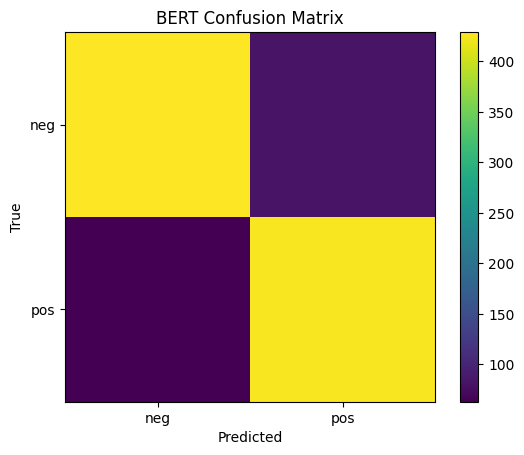

In [39]:
cm = confusion_matrix(bert_labels, bert_preds)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks([0,1], ["neg","pos"])
plt.yticks([0,1], ["neg","pos"])
plt.show()

In [57]:
%%bash
python fine_tune.py \
  --model_name bert-base-uncased \
  --dataset imdb \
  --task seq-classification \
  --text_column text \
  --label_column label \
  --num_labels 2 \
  --epochs 3 \
  --train_bs 16 \
  --eval_bs 32 \
  --lr 2e-5 \
  --log_steps 50 \
  --output_dir ./bert_imdb


{'loss': 0.6608, 'grad_norm': 5.376769542694092, 'learning_rate': 1.9795265515035193e-05, 'epoch': 0.03}
{'loss': 0.4354, 'grad_norm': 6.150688171386719, 'learning_rate': 1.958626572830028e-05, 'epoch': 0.06}
{'loss': 0.3652, 'grad_norm': 8.864812850952148, 'learning_rate': 1.9373000639795267e-05, 'epoch': 0.1}
{'loss': 0.3844, 'grad_norm': 6.011553764343262, 'learning_rate': 1.9159735551290257e-05, 'epoch': 0.13}
{'loss': 0.3739, 'grad_norm': 13.248801231384277, 'learning_rate': 1.8946470462785243e-05, 'epoch': 0.16}
{'loss': 0.4054, 'grad_norm': 4.726548671722412, 'learning_rate': 1.8733205374280233e-05, 'epoch': 0.19}
{'loss': 0.3344, 'grad_norm': 6.128021717071533, 'learning_rate': 1.851994028577522e-05, 'epoch': 0.22}
{'loss': 0.3149, 'grad_norm': 14.875542640686035, 'learning_rate': 1.8306675197270206e-05, 'epoch': 0.26}
{'loss': 0.3417, 'grad_norm': 4.675786018371582, 'learning_rate': 1.8093410108765196e-05, 'epoch': 0.29}
{'loss': 0.2963, 'grad_norm': 11.672778129577637, 'learn

2025-05-06 22:53:45.015193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746572025.034813   81237 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746572025.040746   81237 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/content/fine_tune.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_

In [58]:
%%bash
python fine_tune.py \
  --model_name bert-base-cased \
  --dataset conll2003 \
  --task token-classification \
  --text_column tokens \
  --label_column ner_tags \
  --num_labels 9 \
  --max_length 128 \
  --epochs 3 \
  --train_bs 16 \
  --eval_bs 32 \
  --lr 2e-5 \
  --log_steps 50 \
  --output_dir ./bert_conll


{'loss': 0.8549, 'grad_norm': 1.0141490697860718, 'learning_rate': 1.965072133637054e-05, 'epoch': 0.06}
{'loss': 0.2136, 'grad_norm': 1.7211638689041138, 'learning_rate': 1.927107061503417e-05, 'epoch': 0.11}
{'loss': 0.1265, 'grad_norm': 2.612119197845459, 'learning_rate': 1.88914198936978e-05, 'epoch': 0.17}
{'loss': 0.1136, 'grad_norm': 3.073540210723877, 'learning_rate': 1.851176917236143e-05, 'epoch': 0.23}
{'loss': 0.0953, 'grad_norm': 2.307715892791748, 'learning_rate': 1.813211845102506e-05, 'epoch': 0.28}
{'loss': 0.0856, 'grad_norm': 4.198133945465088, 'learning_rate': 1.775246772968869e-05, 'epoch': 0.34}
{'loss': 0.0707, 'grad_norm': 0.9496470093727112, 'learning_rate': 1.7372817008352315e-05, 'epoch': 0.4}
{'loss': 0.0671, 'grad_norm': 1.420340895652771, 'learning_rate': 1.6993166287015947e-05, 'epoch': 0.46}
{'loss': 0.0717, 'grad_norm': 2.3650970458984375, 'learning_rate': 1.6613515565679577e-05, 'epoch': 0.51}
{'loss': 0.0688, 'grad_norm': 0.9713855981826782, 'learning

2025-05-06 23:06:27.436722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746572787.471041   84434 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746572787.481340   84434 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 3453/3453 [00:00<00:00, 5181.30 examples/s]
/content/fine_tune.py:94: FutureWarning: `tokenizer` is deprecated and will be remo